In [14]:
import os
try:
    from google.colab import drive
    COLAB = True
    print("Estoy en Google CoLab")
    %tensorflow_version 2.x
    !pip install livelossplot
except:
    os.environ["CUDA_VISIBLE_DEVICES"]="0" 
    print("No estoy en Google CoLab")
    COLAB = False

No estoy en Google CoLab


In [15]:
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.datasets import imdb
import numpy as np 

try:
    from livelossplot.tf_keras import PlotLossesCallback
except:
    !pip install livelossplot
    from livelossplot.tf_keras import PlotLossesCallback

batch_size = 32

### Análisis de sentimiento con CNN

Para esta práctica vamos a usar un conjunto de datos muy conocido sobre comentarios de películas. Este conjunto de datos está compuesto por 25.000 sentencias para entrenar y 25.000 para validar nuestro modelo:

In [16]:
MAX_WORDS = 1000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_WORDS)
print(len(x_train), 'secuencias de entrenamiento')
print(len(x_test), 'secuencias de test')

25000 secuencias de entrenamiento
25000 secuencias de test


Nos vamos a quedar con un subconjunto de ellas para evitar problemas de memoria:

In [17]:
x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test = x_test[:10000], y_test[:10000]

Los datos ya vienen condificados. A cada palabra se le asocia un número identificativo. Si trabajamos directamente con el texto este es uno de los primeros pasos que es neceario realizar, pero aquí ya nos lo dan. En el tema de secuencias veremos como realizar nosotros este paso:

In [18]:
x_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 2, 2, 65]

Poder decodificar el texto usando el mapping entre código y palabra:

In [19]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 2,
 2,
 65,
 458,
 2,
 66,
 2,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 2,
 2,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2,
 19,
 14,
 22,
 4,
 2,
 2,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 2,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2,
 2,
 16,
 480,
 66,
 2,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 2,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 2,
 15,
 256,
 4,
 2,
 7,
 2,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 2,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2,
 56,
 26,
 141,
 6,
 194,
 2,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 2,
 18,
 51,
 36,
 28,
 224,
 92,
 25,
 104,
 4,
 226,
 65,
 16,
 3

In [21]:
index = imdb.get_word_index()
reverse_index = dict([(value, key) for (key, value) in index.items()]) 
def decode_sentence(sentence):
    return " ".join([reverse_index.get(code - 3, "#") for code in sentence])
    

decode_sentence(x_train[0])

"# this film was just brilliant casting # # story direction # really # the part they played and you could just imagine being there robert # is an amazing actor and now the same being director # father came from the same # # as myself so i loved the fact there was a real # with this film the # # throughout the film were great it was just brilliant so much that i # the film as soon as it was released for # and would recommend it to everyone to watch and the # # was amazing really # at the end it was so sad and you know what they say if you # at a film it must have been good and this definitely was also # to the two little # that played the # of # and paul they were just brilliant children are often left out of the # # i think because the stars that play them all # up are such a big # for the whole film but these children are amazing and should be # for what they have done don't you think the whole story was so # because it was true and was # life after all that was # with us all"

El siguiente paso es equiparar el tamaño de nuestras secuencias. Nuestra red tendrá un tamaño de entrada fijado, por lo que todas aquellas secuencias que tengan una tamaño infererior la debemos a rellenar hasta llegar a la longitud establecida (en este caso 80). La función `pad_sequences` lleva a cabo esta tarea por nosotros. Como código de relleno se usa el 0.

Vamos a buscar una secuencia con un tamaño menor a 80 para ver el resultado tras el relleno:

In [6]:
MAXLEN = 80

i = [i for i, s in enumerate(x_train) if len(s) < 80][0]
print(x_train[i])

[1, 778, 128, 74, 12, 630, 163, 15, 4, 2, 2, 2, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 2, 173, 4, 749, 2, 16, 2, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]


In [7]:
MAXLEN = 80
print('Equiparamos el tamaño de las secuencias')
x_train = sequence.pad_sequences(x_train, maxlen=MAXLEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAXLEN)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train[i])

Equiparamos el tamaño de las secuencias
x_train shape: (10000, 80)
x_test shape: (10000, 80)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   1 778 128  74  12 630 163  15   4   2   2   2   2  32  85 156  45
  40 148 139 121 664 665  10  10   2 173   4 749   2  16   2   8   4 226
  65  12  43 127  24   2  10  10]


Para este problema vamos a usar convolucionales de una 1 dimensión. Como en el caso de las convolucionales 2D, se esperan los canales. En este caso, los canales los vamos a generar condificando cada palabra (su código) en one-hot.

In [8]:
x_train = keras.utils.to_categorical(x_train, MAX_WORDS)
x_test = keras.utils.to_categorical(x_test, MAX_WORDS)
x_train.shape

(10000, 80, 1000)

Creamos la red   con algunas convolucionales, max-pooling y las capas densas para llevar a cabo la clasificación:

In [9]:
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(MAXLEN, MAX_WORDS)),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(),
    Conv1D(32, 3, activation='relu'),
    Conv1D(32, 3, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 78, 32)            96032     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 76, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 38, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 36, 32)            3104      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 34, 32)            3104      
_________________________________________________________________
flatten (Flatten)            (None, 1088)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2

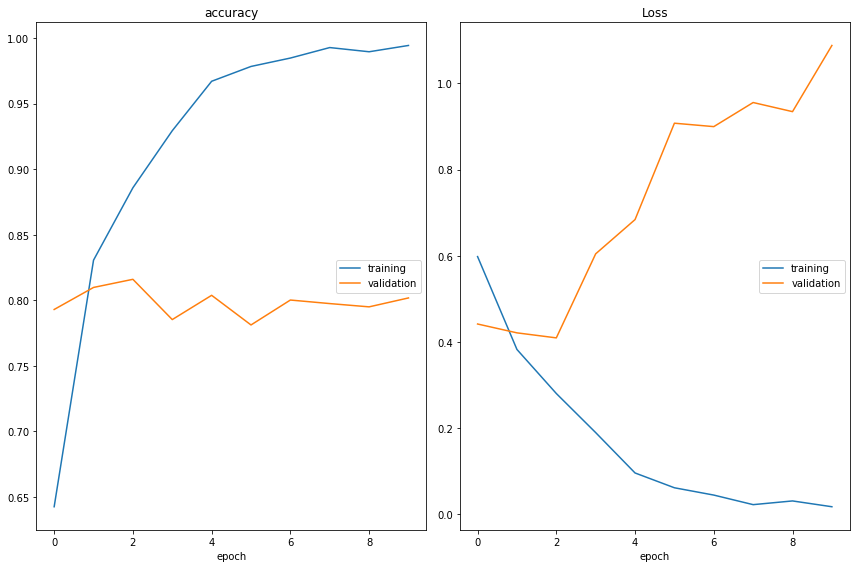

accuracy
	training         	 (min:    0.643, max:    0.994, cur:    0.994)
	validation       	 (min:    0.781, max:    0.816, cur:    0.802)
Loss
	training         	 (min:    0.018, max:    0.598, cur:    0.018)
	validation       	 (min:    0.410, max:    1.088, cur:    1.088)
313/313 [==============================] - 5s 15ms/step - loss: 0.0178 - accuracy: 0.9943 - val_loss: 1.0880 - val_accuracy: 0.8018


In [10]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=32,
          epochs=10,
          callbacks=[PlotLossesCallback()],
          validation_data=(x_test, y_test))
